In [1]:
from PIL import Image
from numpy import *
from pylab import *
import scipy.misc

In [2]:
from scipy.cluster.vq import *

In [3]:
import imtools
import pickle

In [4]:
imlist = imtools.get_imlist('selected_fontimages/')
imnbr = len(imlist)

In [5]:
with open('font_pca_modes.pkl', 'rb') as f:
    immean = pickle.load(f)
    V = pickle.load(f)

In [6]:
immatrix = array([array(Image.open(im)).flatten() for im in imlist], 'f')

In [7]:
immean = immean.flatten()
projected = array([dot(V[:40], immatrix[i]-immean) for i in range(imnbr)])

In [8]:
cluster_num = 3
projected = whiten(projected)
centroids, distortion = kmeans(projected, cluster_num)

In [9]:
code, distance = vq(projected, centroids)

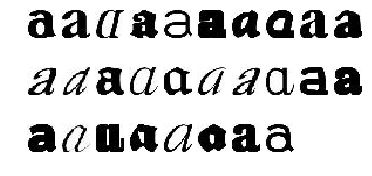

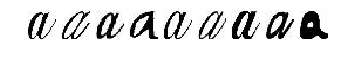

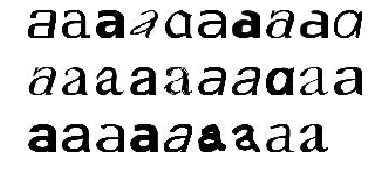

In [10]:
for k in range(cluster_num):
    ind = where(code==k)[0]
    figure()
    gray()
    for i in range(minimum(len(ind), 40)):
        subplot(4, 10, i+1)
        imshow(immatrix[ind[i]].reshape((25, 25)))
        axis('off')
show()

In [11]:
def divide_branch(data, branch, k):
    div = min(k, len(branch))
    if div<=1:
        return list(branch)
    centroids, distortion = kmeans(data[branch], k)
    code, distance = vq(data[branch], centroids)
    new_branch = []
    for i in range(k):
        ind = where(code==i)[0]
        if len(ind)==0:
            continue
        else:
            new_branch.append(divide_branch(data, branch[ind], k))
    return new_branch

In [12]:
tree = array([i for i in range(projected.shape[0])])
branches = divide_branch(projected, tree, 4)

In [13]:
print branches

[[[[[50], [52], [13], [54]], [49], [[23], [[8], [30]], [26], [[61], [22], [3]]], [59]], [[41], [12], [5], [48]], [[[33], [37], [35]], [63], [58], [[56], [15], [17]]], [[60], [4], [[1], [11], [9], [64]], [[25], [[40], [16], [10]], [45], [[62], [43], [24]]]]], [[[38], [21], [65]], [[28], [36]], [29], [[7], [31], [57], [[34], [53]]]], [[[44], [0]], [42], [[47], [39], [55]], [[18], [46]]], [[[20], [14]], [19], [6], [[32], [2], [27], [51]]]]


In [14]:
def get_depth(t):
    if len(t)<2:
        return 1
    else:
        return max([get_depth(tt) for tt in t])+1

In [15]:
def get_height(t):
    if (len(t)<2):
        return 1
    else:
        return sum([get_height(tt) for tt in t])

In [16]:
from PIL import Image, ImageDraw

In [17]:
def draw_node(node, draw, x, y, s, iml, im):
    if len(node)<1:
        return
    if len(node)==1:
        nodeim = Image.open(iml[node[0]])
        nodeim.thumbnail([20, 20])
        ns = nodeim.size
        im.paste(nodeim, [int(x), int(y-ns[1]//2), int(x+ns[0]), int(y+ns[1]-ns[1]//2)])
    else:
        ht = sum([get_height(n) for n in node])*20/2
        h1 = get_height(node[0])*20/2
        h2 = get_height(node[-1])*20/2
        top = y-ht
        bottom = y+ht
        draw.line((x, top+h1, x, bottom-h2), fill=(0, 0, 0))
        ll = 1*s
        y = top
        for i in range(len(node)):
            y += get_height(node[i])*20/2
            draw.line((x, y, x+ll, y), fill=(0, 0, 0))
            draw_node(node[i], draw, x+ll, y, s, imlist, im)
            y += get_height(node[i])*20/2

In [18]:
def draw_dendrogram(node, iml, filename='kclusters.jpg'):
    rows = get_height(node)*20+40
    cols = 1200

    s = float(cols-150)/get_depth(node)

    im =  Image.new('RGB', (cols, rows), (255, 255, 255))
    draw = ImageDraw.Draw(im)

    draw.line((0, rows/2, 20, rows/2), fill=(0, 0, 0))
    draw_node(node, draw, 20, (rows/2), s, iml, im)
    im.save(filename)
    im.show()

In [19]:
draw_dendrogram(branches, imlist, filename='k_fonts.jpg')